# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fraud = pd.read_csv(r'../fraud_detect.csv')

In [2]:
'''
Meaning of each column:


This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start 
with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start 
with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the 
fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by 
transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. 
An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
'''

'\nMeaning of each column:\n\n\nThis is a sample of 1 row with headers explanation:\n\n1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0\n\nstep - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).\n\ntype - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.\n\namount - amount of the transaction in local currency.\n\nnameOrig - customer who started the transaction\n\noldbalanceOrg - initial balance before the transaction\n\nnewbalanceOrig - new balance after the transaction\n\nnameDest - customer who is the recipient of the transaction\n\noldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start \nwith M (Merchants).\n\nnewbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start \nwith M (Merchants).\n\nisFraud - This is the transactions made by the fraudulent agents inside the si

In [3]:
#Keeping only the first 100000 rows:

fraud_sample = fraud.sample(n=100000)
fraud_sample.shape

(100000, 11)

In [4]:
fraud_sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
980473,44,CASH_IN,239440.60,C2089344413,22200180.78,22439621.38,C644931594,893489.89,654049.29,0,0
1401078,139,CASH_OUT,298348.03,C438772830,0.00,0.00,C217227262,366020.42,664368.45,0,0
1454738,140,CASH_OUT,147525.36,C2010381719,0.00,0.00,C328374184,1822829.29,1970354.64,0,0
5319891,374,CASH_OUT,187312.99,C1049894639,20109.00,0.00,C94233257,11801.61,199114.60,0,0
1159390,131,CASH_IN,21558.16,C1317864012,10340.00,31898.16,C181164250,494591.92,473033.77,0,0


In [5]:
#Descriptive statistics:

fraud_sample.info()
#Apparently there are no null values in all columns.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 980473 to 5867503
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


In [6]:
fraud_sample.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.00000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.31683,1.823385e+05,8.362503e+05,8.579324e+05,1.102253e+06,1.227300e+06,0.001290,0.0
std,142.31864,6.896326e+05,2.883859e+06,2.919700e+06,3.271284e+06,3.620646e+06,0.035894,0.0
min,1.00000,2.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,156.00000,1.335603e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,238.00000,7.428338e+04,1.476550e+04,0.000000e+00,1.303947e+05,2.105612e+05,0.000000,0.0
75%,334.00000,2.076241e+05,1.084107e+05,1.493544e+05,9.378787e+05,1.099143e+06,0.000000,0.0
max,736.00000,6.676127e+07,3.157304e+07,3.182947e+07,1.587039e+08,2.362512e+08,1.000000,0.0


In [7]:
#Number of frauds in the dataset:

fraud_sample['isFraud'].value_counts()

#Apparently we have only 126 frauds in a total of 100k rows. High class imbalance.

0    99871
1      129
Name: isFraud, dtype: int64

In [8]:
#Same for the flagged frauds:

fraud_sample['isFlaggedFraud'].value_counts()

#There are no flagged frauds, which means that there were no attempts to transfer more than 200.000 in a single transaction.
#Also high class imbalance

0    100000
Name: isFlaggedFraud, dtype: int64

In [9]:
#Number of transactions per each type of payment:

fraud_sample['type'].value_counts()

#Again, we can see class imbalance.

CASH_OUT    34899
PAYMENT     33810
CASH_IN     22247
TRANSFER     8386
DEBIT         658
Name: type, dtype: int64

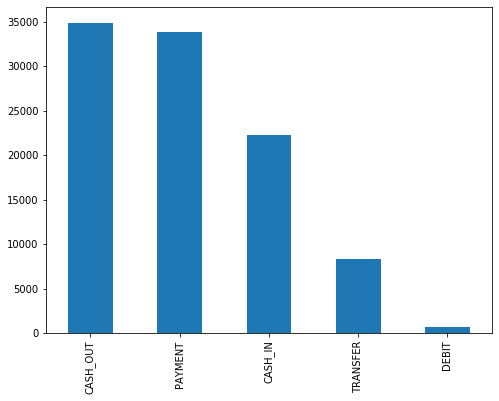

In [10]:
#Bar plots are good to see the class imbalance of the fraud/not fraud and isflaggedfraud/is not flaggedfraud:
fig = plt.figure(figsize = (8,6))
fraud_sample['type'].value_counts().plot.bar(ylim = 0)
plt.show()

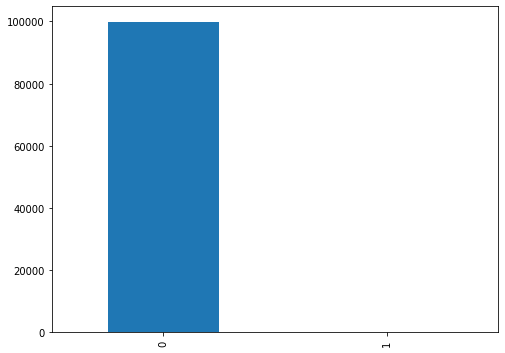

In [11]:
fig = plt.figure(figsize = (8,6))
fraud_sample['isFraud'].value_counts().plot.bar(ylim = 0)
plt.show()

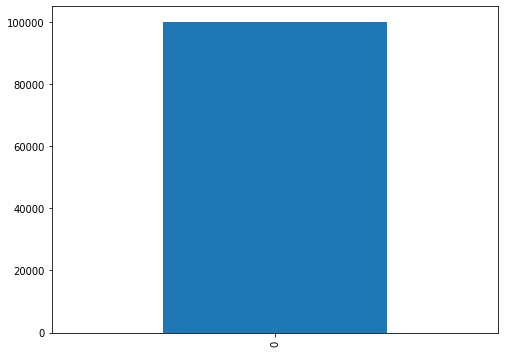

In [12]:
fig = plt.figure(figsize = (8,6))
fraud_sample['isFlaggedFraud'].value_counts().plot.bar(ylim = 0)
plt.show()

### What is the distribution of the outcome? 

In [13]:
#Number of frauds in the dataset:

fraud_sample['isFraud'].value_counts()

#Apparently we have only 116 frauds in a total of 100k rows. High class imbalance.

0    99871
1      129
Name: isFraud, dtype: int64

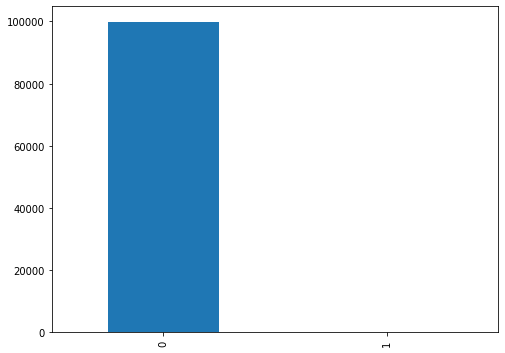

In [14]:
fig = plt.figure(figsize = (8,6))
fraud_sample['isFraud'].value_counts().plot.bar(ylim = 0)
plt.show()

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [15]:
fraud_sample['step'].unique()

array([ 44, 139, 140, 374, 131, 208, 332, 326, 180, 249, 136, 190, 686,
       279, 370, 211, 141,  10,  11, 284,  39, 323, 178, 288, 401, 352,
       184, 393, 358, 163,  19, 303, 159, 186,  20, 130, 335, 225, 286,
       260, 347, 281, 156, 181, 182, 157, 134, 404, 276,  47, 373, 158,
       205, 396,  18, 514,  21, 258, 210, 300, 301, 204, 237, 565,  12,
       692,  33, 297,  35, 209, 573, 397,  15, 189, 164, 328, 160, 138,
       327, 353, 307,   9, 252, 356, 330, 500, 275,  42, 206, 322, 167,
       212, 238, 282, 250, 423, 129,  14,  36, 331, 522, 142,  17, 277,
       400, 135, 379, 357, 681,  43, 637, 231, 165, 349, 298,  38, 285,
       253, 564, 233, 207, 179, 360, 306, 256,  45, 274, 378, 354, 230,
       371,  41, 381, 228, 203, 120,  95, 234,  16, 188, 214, 154, 403,
       350, 544, 309, 588, 227, 236, 399,  13, 280, 383, 251, 394, 348,
       355, 177, 133, 283, 161, 191, 169, 599, 229,  37, 308, 289,  46,
       310, 235, 548, 372, 376, 398, 153, 640, 380, 455, 187, 34

In [16]:
# It may be better to change it into days, for example, so we don't have a lot of unique values.

fraud_sample['step'] = (fraud_sample['step']/24).astype(int)
fraud_sample['step'].unique() #different days

array([ 1,  5, 15,  8, 13,  7, 10, 28, 11,  0, 12, 16, 14,  6,  9, 21, 23,
       20, 17, 26,  3, 22, 24, 18, 25,  4,  2, 19, 27, 29, 30])

In [17]:
fraud_sample.shape

#Done

(100000, 11)

In [18]:
#To continue cleaning the dataset, I will drop columns that aren't important, like the name of the customers, and the flagged frauds.
#The flagged frauds do not add anything interesting.

fraud_sample = fraud_sample.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
fraud_sample.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
980473,1,CASH_IN,239440.60,22200180.78,22439621.38,893489.89,654049.29,0
1401078,5,CASH_OUT,298348.03,0.00,0.00,366020.42,664368.45,0
1454738,5,CASH_OUT,147525.36,0.00,0.00,1822829.29,1970354.64,0
5319891,15,CASH_OUT,187312.99,20109.00,0.00,11801.61,199114.60,0
1159390,5,CASH_IN,21558.16,10340.00,31898.16,494591.92,473033.77,0


In [19]:
fraud_sample.info()
#Everything is ok, so I will proceed to create dummies for the models.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 980473 to 5867503
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int32  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   oldbalanceOrg   100000 non-null  float64
 4   newbalanceOrig  100000 non-null  float64
 5   oldbalanceDest  100000 non-null  float64
 6   newbalanceDest  100000 non-null  float64
 7   isFraud         100000 non-null  int64  
dtypes: float64(5), int32(1), int64(1), object(1)
memory usage: 6.5+ MB


In [20]:
fraud_sample.shape

(100000, 8)

In [21]:
sample_dummy = pd.get_dummies(fraud_sample)
sample_dummy.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
980473,1,239440.60,22200180.78,22439621.38,893489.89,654049.29,0,1,0,0,0,0
1401078,5,298348.03,0.00,0.00,366020.42,664368.45,0,0,1,0,0,0
1454738,5,147525.36,0.00,0.00,1822829.29,1970354.64,0,0,1,0,0,0
5319891,15,187312.99,20109.00,0.00,11801.61,199114.60,0,0,1,0,0,0
1159390,5,21558.16,10340.00,31898.16,494591.92,473033.77,0,1,0,0,0,0


In [22]:
sample_dummy.shape

(100000, 12)

### Run a logisitc regression classifier and evaluate its accuracy.

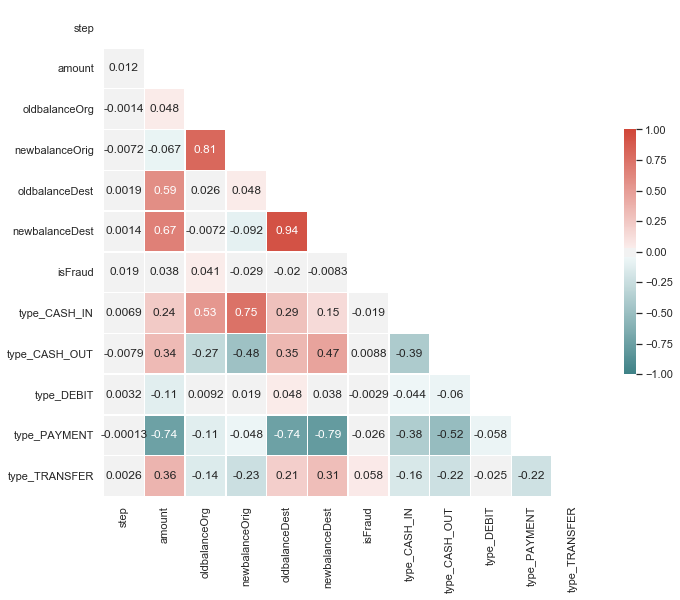

In [23]:
#In order to implement the model, I will see the features that are important or not, evaluating their correlation:

# check with multilinear
corr = sample_dummy.corr(method='spearman')

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 15, as_cmap = True)

# annot=True so as to show the value
# Draw the heatmap with the mask and correct aspect ratio
# vmin=-1, vmax=1 gets the whole scale
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
             square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()



In [24]:
#Judging by the heatmap, I will drop newblalanceOrig, newbalanceDest, ddbalanceDest, type_CASH_IN and type_PAYMENT:

sample_dummy = sample_dummy.drop(['newbalanceOrig', 'newbalanceDest', 'oldbalanceDest', 'type_CASH_IN', 'type_PAYMENT'], axis = 1)

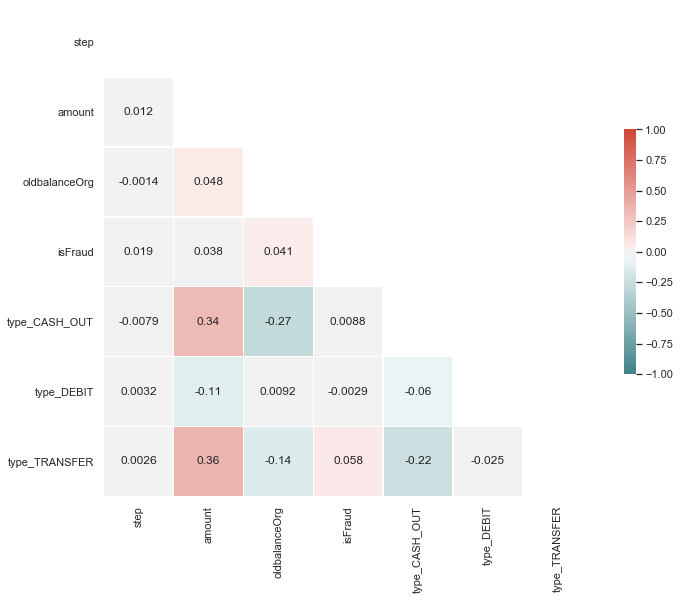

In [25]:
# check with multilinear
corr = sample_dummy.corr(method='spearman')

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 15, as_cmap = True)

# annot=True so as to show the value
# Draw the heatmap with the mask and correct aspect ratio
# vmin=-1, vmax=1 gets the whole scale
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
             square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [26]:
from sklearn.model_selection import train_test_split

X = sample_dummy.drop(['isFraud'], axis = 1) # features
y = sample_dummy['isFraud'] # label

# splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [27]:
X_train.shape

(80000, 6)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Initializing the model:
model = LogisticRegression(max_iter=1000)

# max_iter = 2000 above avoids error message (max number of interations reached)
# if the max number of interations is reached, we may not reach the best model

#Fitting the model
model.fit(X_train, y_train)

#predictions: test data
y_pred = model.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('-------------------------------------------------------')

# accuracy_score
# fitted X_test data vs. y_test data (actual answer)
print('Accuracy score')
print(accuracy_score(y_pred,y_test))

print('-------------------------------------------------------')
# classification report
print('Classification report')
print(classification_report(y_pred,y_test))

Confusion matrix
[[19973    27]
 [    0     0]]
-------------------------------------------------------
Accuracy score
0.99865
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000
           1       0.00      0.00      0.00         0

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       1.00      1.00      1.00     20000



C:\Users\joanr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Now pick a model of your choice and evaluate its accuracy.

In [29]:
# I will pick a decision tree, and also a random forest, to compare both models:

#Decision tree:
from sklearn.tree import DecisionTreeClassifier

# create instance of the model
dtc = DecisionTreeClassifier()

# train the model
dtc.fit(X_train, y_train)

#predictions: test data
y_pred = dtc.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('-------------------------------------------------------')

# accuracy_score
# fitted X_test data vs. y_test data (actual answer)
print('Accuracy score')
print(accuracy_score(y_pred,y_test))

print('-------------------------------------------------------')
# classification report
print('Classification report')
print(classification_report(y_pred,y_test))

Confusion matrix
[[19952    14]
 [   21    13]]
-------------------------------------------------------
Accuracy score
0.99825
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19966
           1       0.48      0.38      0.43        34

    accuracy                           1.00     20000
   macro avg       0.74      0.69      0.71     20000
weighted avg       1.00      1.00      1.00     20000



In [30]:
# Random forest:

from sklearn.ensemble import RandomForestClassifier

# create an instance of the model
forest = RandomForestClassifier()

# fit the model
forest.fit(X_train, y_train)

# predict for test 
y_pred = forest.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('-------------------------------------------------------')

# accuracy_score
# fitted X_test data vs. y_test data (actual answers)
print('Accuracy score')
print(forest.score(X_test,y_test))
#print(accuracy_score(y_pred,y_test)) does the exact same thing as forest.score(X_test,y_test)
print('-------------------------------------------------------')

# classification report
print('Classification report')
print(classification_report(y_pred,y_test)) 

# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

Confusion matrix
[[19972    15]
 [    1    12]]
-------------------------------------------------------
Accuracy score
0.9992
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19987
           1       0.44      0.92      0.60        13

    accuracy                           1.00     20000
   macro avg       0.72      0.96      0.80     20000
weighted avg       1.00      1.00      1.00     20000



### Which model worked better and how do you know?

In [18]:
'''
First of all, the most important parameter in detecting fraud, is the recall. We also have to consider the class imbalance
in this class, which is very high (we may consider oversampling or undersampling to see compare results), it was this class
imbalance that probably led to the overfit. The decision tree and random forest both give a decent/good recall of 0.70 and 0.92,
which means we catched 70% and 92% of the frauds, respectively. Therefore, the random forest is best model.
'''

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.